In [1]:
import numpy as np
import torch
import re, copy, os, chardet, time
from torch import nn
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score,recall_score,precision_score,confusion_matrix,matthews_corrcoef 
from sklearn import metrics
from scipy import stats
import pickle
import shutil
import dataProcess
import pandas as pd
from DSpaLaRefinerModelDiscWPos import *
import matplotlib.pyplot as plt
from matplotlib import font_manager
font_path = font_manager.findfont(font_manager.FontProperties(family='Arial'))
plt.rcParams["font.family"] = "Arial"

In [2]:
OutPath = './out_11_6516Repeat0'
device ='cpu'
feature_names = pd.read_csv(r'C:\LvXiang\Work\Work1\CodeReconstrut\Code_management\feature_name.csv',nrows=0).columns[1:].tolist()

In [3]:
with open(OutPath+os.sep+'paraDict.pt', 'rb') as FOUT:
    paraDict = pickle.load(FOUT)
paraDict['device'] ='cpu'
model_pre = WrappedModel(**paraDict).float().to(device)
model_pre.load_state_dict(torch.load(OutPath+os.sep+'bestStateDict.pt'))

<All keys matched successfully>

In [4]:
dataPath = './SplitData/data_hospital_11_0.pt'   
with open(OutPath+os.sep+'dataSetCollect_pre.pt','rb') as FOUT:
    data_collect = pickle.load(FOUT)
dataTrain =  data_collect[0]
dataVal =  data_collect[1]
dataTest =  data_collect[2]

In [5]:
Overlap_option=True

In [6]:
FigSavePath = OutPath+os.sep+'drawFig'
if os.path.exists(FigSavePath):
    shutil.rmtree(FigSavePath)
os.makedirs(FigSavePath,exist_ok=True)

## The overlap of nearest neighbor data for each Landmark

In [7]:
def overlap(model,data,FigSavePath=FigSavePath,K=1500):
    data_y = data['y']
    weight_list = [np.abs(model.discLayers[i].linear.weight.detach().cpu().numpy()) for i in range(len(model.discLayers))]
    layerprob_list = [data['dist_prob'][i].detach().cpu().numpy() for i in data['dist_prob'].keys()]
    all_layerprob = np.concatenate(layerprob_list,axis=0)
    sorted_indices_list = [np.argsort(i) for i in weight_list]
    count = [((i.flatten()<=0).sum(),(i.flatten()>0).sum()) for i in weight_list]
    tick_list = [0]
    tick = 0
    for i in count:
        for j in i:
            tick += j
            tick_list.append(tick)
    all_layerprob_sort_list =  [layerprob_list[i][sorted_indices_list[i]][0] for i in range(len(model.discLayers))]
    all_layerprob_sort = np.concatenate(all_layerprob_sort_list,axis=0)
    top_k_metrics_byt,overlap_matrix_byt = top_k_overlap_byt(all_layerprob_sort,k=K)
    plt.figure(figsize=(8, 6),dpi=300)
    plt.imshow(overlap_matrix_byt, cmap='Reds', interpolation='nearest')
    desired_ticks = tick_list
    plt.xticks(desired_ticks)
    plt.yticks(desired_ticks)
    plt.colorbar()
    plt.savefig(FigSavePath+os.sep+'Overlap%s.png'%K, dpi=600)
    plt.show()

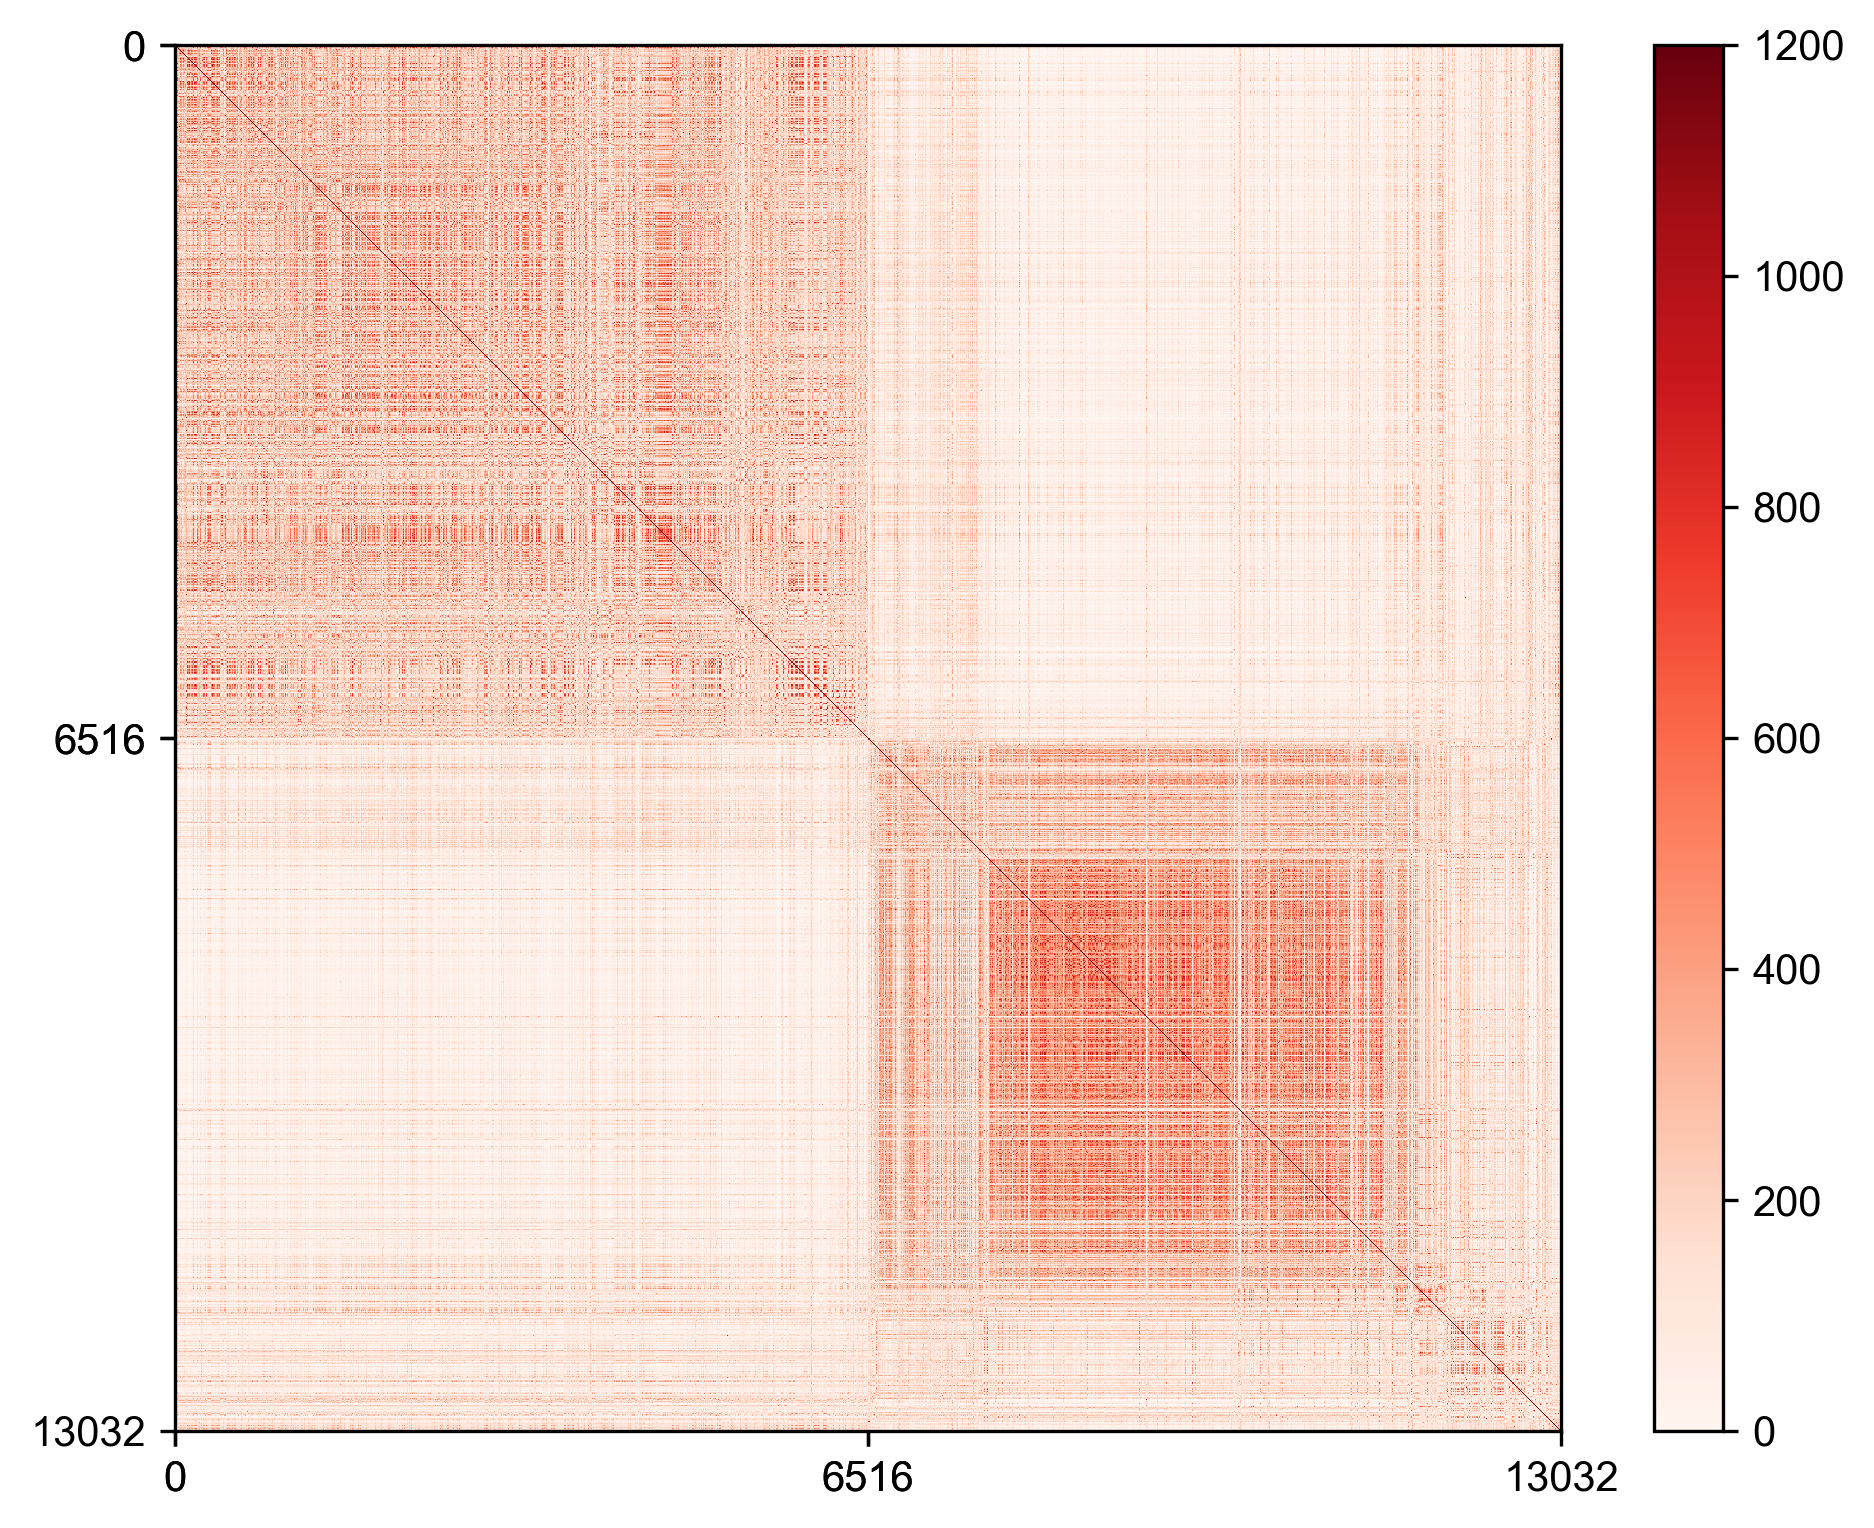

In [8]:
if Overlap_option == True:
    overlap(model_pre,dataTest,FigSavePath,K=1200)

## Individual sample analysis

In [9]:
with open(OutPath+os.sep+'singleSampleResult_Test'+os.sep+'dataSetCollect_pre_sampleTry_Test2.pt','rb') as FOUT:
    datatmp = pickle.load(FOUT)

In [10]:
def ISA_main(data,model,lenY,mean_path=None,sampleIndex=1,FigSavePath=FigSavePath,device=device,compute_mean = False):
    '''
    this is a function for drawing analysis picture. 
    The data should be a dict from the model.predict_singleSample containing dict_keys(['x', 'y', 'mask', 'y_pred', 'pred_probability', 'dist_prob'])
    The model is the optimized DSpaLaRefinerModel. 
    compute_mean is used for compute the mean_distF
    '''
    #Compute the necessary variables for drawing
    dataTest_ypredProbFx1 = torch.tensor(data['pred_probability']) ##pred_probability is the dist probability before softmax
    dataTest_distFx1 = torch.concat([data['dist_prob'][i].t() for i in data['dist_prob'].keys()],dim=1) ## 'dist_prob' containing mutiple class, each class represents the dist between the landmarks of specific class and the data.
    disc_w_list = [torch.abs(model.discLayers[i].linear.weight.detach().cpu()) for i in range(len(model.discLayers))] ## The votingWeight of landmarks
    VotingW01 =  torch.concat(disc_w_list,axis=1) ## The votingWeight of landmarks   
    # print(VotingW01.shape)
    Wmuldist = VotingW01*dataTest_distFx1 ## The VotingWeight of landmarks * dist
    # print(Wmuldist[0,0:6516].sum())
    # assert False


    
    ## The sorted index of the landmarks by VotingWeight
    sort_index = [torch.argsort(disc_w_list[i]) for i in range(len(disc_w_list))] 

    lenLandmark_list = []
    len_tmp = 0
    for i in sort_index:
        lenLandmark_list.append(len_tmp)
        len_tmp+=i.shape[-1]

    sort_index_new = torch.concat([sort_index[i]+lenLandmark_list[i] for i in range(len(sort_index))],dim=1) ## The sorted index of the landmarks by VotingWeight
    
    Wmuldist_sort = Wmuldist[:,sort_index_new].squeeze(0)

    ##Count of the landmarks of each class and each sign
    count = [((i.flatten()<=0).sum(),(i.flatten()>0).sum()) for i in disc_w_list]
    # print(count)
    tick_list = [0]
    tick = 0
    for i in count:
        for j in i:
            if j != 0:
                tick += j
                tick_list.append(tick.item())
    dist_DiffLand_list = []
    

    
    type_list = tick_list[1:]

    cut = 0
    for tmp_cut in type_list:
        dist_DiffLand_list.append(Wmuldist_sort[0,cut:tmp_cut].sum())
        cut = tmp_cut

    # print(dist_DiffLand_list)
    # assert False
    ##The dist contribution of each class of the landmarks  
    num_class = lenY
    Dist_class = []
    for i in range(num_class):
        Dist_class.append(dist_DiffLand_list[i])
    Dist_class_tensor = torch.tensor(Dist_class).unsqueeze(0)


    
    #The dist on the feature level between the sample and the landmarks 
    data_x1 = data['x']
    data_m1 = data['mask']
    data_x1_norm = model_pre.norm(torch.tensor(data_x1).to(device))
    
    
    dist_fx1_list = []
    for i in range(len(model_pre.WDDList)):
        _,_,_,dist_fx1 = model_pre.WDDList[i].distDi(data_x1_norm,mask= torch.tensor(data_m1).to(device))
        dist_fx1_list.append(dist_fx1)

    ##The weighted dist on the feature level between the sample and the landmarks ((W**(1/feature))*distF)
    tmp_Distx1F_list = []
    for i in range(len(model_pre.WDDList)):
        tmp_Distx1F_list.append(torch.exp(-1*torch.abs(model_pre.WDDList[i].gamma)*dist_fx1_list[i]))
    tmp_Distx1F_01 = torch.concat(tmp_Distx1F_list)[:,0,:]
    tmp_Distx1F_01_03 = tmp_Distx1F_01[:].detach().cpu().t()


    
    # print(tmp_Distx1F_01_03.shape)
    # assert False
    VotingW01_03 = VotingW01[0,:]
    tmpDistx1F_01_03_mulW = pow(np.abs(VotingW01_03),1/data_x1.shape[-1]).unsqueeze(0)*tmp_Distx1F_01_03
    tmpDistx1F_01_03_mulW_sort = tmpDistx1F_01_03_mulW[:,sort_index_new].squeeze(1)
    tmpDistx1F_0_sort_sumList = []
    for i in range(len(tick_list)-1):
        tmpDistx1F_0_sort_sumList.append(tmpDistx1F_01_03_mulW_sort[:,tick_list[i]:tick_list[i+1]].sum(1))
    # print(tmpDistx1F_0_sort_sumList)
    # assert False
    
    numOfEachclassList = [] ##The number of each type of landmarks  
    for i in range(len(tick_list)-1):
        num_of_eachClass = tick_list[i+1]-tick_list[i]
        numOfEachclassList.append(num_of_eachClass)
    ##Just for binary question
    '''In practice, we should compute the diff_01_posneg_add for the training sample and get a average of each feture',which means the 
    diff_0_posneg  = tmpDistx1F_0_sort_sumList[0]/numOfEachclassList[0]-tmpDistx1F_0_sort_sumList[1]/numOfEachclassList[1]
    diff_1_posneg  = tmpDistx1F_0_sort_sumList[3]/numOfEachclassList[3]-tmpDistx1F_0_sort_sumList[2]/numOfEachclassList[2]
    diff_01_posneg_add_singleSample = diff_0_posneg+diff_1_posneg #shape:f
    should be compute for each sample firstly.
    then concat all of the diff_01_posneg_add_singleSample to be a new matrix:diff_01_posneg_add stored in mean_distF.pk #shape:n*f,(In next Window)
    
    and get the mean of the feature contribution (row_mean), finally we can get the diff_01_posneg_add_minusMean = diff_01_posneg_add_singleSample - row_mean
    '''
    
    diff_0_posneg  = -(tmpDistx1F_0_sort_sumList[0]/numOfEachclassList[0])
    diff_1_posneg  = tmpDistx1F_0_sort_sumList[1]/numOfEachclassList[1]
    diff_01_posneg_add_singleSample = diff_0_posneg+diff_1_posneg
    diff_01_posneg_add_singleSample = torch.masked_fill(diff_01_posneg_add_singleSample,torch.tensor(data_m1[0]),np.nan)
    
    
    if compute_mean:
        return diff_01_posneg_add_singleSample
    

    else:
        with open(mean_path,'rb') as FIDO:
            diff_01_posneg_add = pickle.load(FIDO)
        # print(diff_01_posneg_add)
        nan_mask = torch.isnan(diff_01_posneg_add)
        valid_mask = ~nan_mask
        diff_01_posneg_add_mask = torch.where(nan_mask, torch.zeros_like(diff_01_posneg_add), diff_01_posneg_add)
        row_sum = torch.sum(diff_01_posneg_add_mask, dim=0)
        row_valid_count = torch.sum(valid_mask, dim=0)
        row_mean = row_sum / row_valid_count
        # print(row_mean)
        diff_01_posneg_add_minusMean = diff_01_posneg_add_singleSample - row_mean
        print(row_mean)
        ##drawing pictures
        FCIS(diff_01_posneg_add_minusMean,feature_names,FigSavePath,sampleIndex)

In [11]:
def DEL(X,tick_list,FigSavePath,sampleIndex):
    plt.figure(figsize=(4, 0.5),dpi=300)
    img = plt.imshow(X,cmap='Reds',interpolation='nearest',aspect='auto',vmin=0,vmax=150)
    plt.xlim(-150, 13182)
    plt.xticks(tick_list)
    plt.yticks([])
    cbar = plt.colorbar(img, ticks=[0, 300],fraction=0.046, pad=0.04)  
    cbar.ax.set_yticklabels(['0', '>300'])  
    plt.savefig(FigSavePath+os.sep+'ContriOfLM%s.png'%sampleIndex, dpi=600,bbox_inches = 'tight')
    plt.show()   

In [12]:
def DC(X,FigSavePath,sampleIndex):
    plt.figure(figsize=(4,0.5),dpi=600)
    tmp = torch.tensor(X).unsqueeze(0)
    plt.imshow(tmp,cmap='coolwarm',aspect=0.8,alpha =0.5) 
    for i in range(len(np.arange(0, 1,1))):
        for j in range(len([0,1,2,3])):
            print('data[{},{}]:{}'.format(i, j,tmp[i, j]))
            plt.text(j, i, "{:.4f}".format(tmp[i, j]),
                    ha="center", va="center", color="black",fontsize=5)
    plt.xticks([0,1,2,3],['Class0 neg weight','Class0 pos weight','Class1 neg weight','Class1 pos weight'],fontsize=3)
    plt.yticks([])
    plt.tick_params(axis='both', which='both', length=0)
    # plt.colorbar()
    plt.savefig(FigSavePath+os.sep+'ContriOfLMbyCategory%s.png'%sampleIndex, dpi=600,bbox_inches = 'tight')
    plt.show()

In [13]:
def SumDCL(X,FigSavePath,sampleIndex):
    plt.figure(figsize=(4,0.5),dpi=600)
    # tmp = torch.tensor(dist_DiffLand_list).unsqueeze(0)
    plt.imshow(X,cmap='GnBu',aspect=0.8,alpha =0.5) 
    
    for i in range(len(np.arange(0, 1,1))):
        for j in range(len([0,1])):
            print('data[{},{}]:{}'.format(i, j,X[i, j]))
            plt.text(j, i, "{:.4f}".format(X[i, j]),
                    ha="center", va="center", color="black",fontsize=5)
    
    
    plt.xticks([0,1],['Class0:Normal','Class1:T2DM'],fontsize=3)
    plt.yticks([])
    plt.tick_params(axis='both', which='both', length=0)
    # plt.colorbar()
    plt.savefig(FigSavePath+os.sep+'SumContriOfLM%s.png'%sampleIndex, dpi=600,bbox_inches = 'tight')
    plt.show()

In [14]:
def heatmapofLaFe(X,tick_list,feature_names,FigSavePath,sampleIndex):
    plt.figure(figsize=(10, 10),dpi=300)
    plt.imshow(X,cmap='GnBu',interpolation='nearest',aspect='auto')
    plt.xticks(tick_list)
    plt.yticks(np.arange(0,39,1),feature_names)
    plt.colorbar()
    plt.savefig(FigSavePath+os.sep+'FeaHeatMap%s.png'%sampleIndex, dpi=600,bbox_inches = 'tight')
    plt.show() 
    

### The feature contribution  of each indicator to the classification of the individual sample

In [15]:
def FCIS(X,feature_names,FigSavePath,sampleIndex):
    plt.figure(figsize=(1, 10),dpi=300)
    img= plt.imshow(X.unsqueeze(0).t(),cmap='coolwarm',aspect='auto',vmin=-0.51,vmax=0.51)
    for i in range(len(np.arange(0, 39,1))):
        for j in range(len((np.arange(0, 1,1)))):
            # print('data[{},{}]:{}'.format(i, j,diff_01_posneg_add.unsqueeze(0).t()[i, j]))
            plt.text(j, i, "{:.4f}".format(X.unsqueeze(0).t()[i, j]),
                    ha="center", va="center", color="black",fontsize=5)
    plt.xticks([])
    plt.yticks(np.arange(0,len(feature_names),1),feature_names)
    cbar = plt.colorbar(img)
    cbar.set_ticks(np.arange(-0.5, 0.51, 0.1)) 
    plt.savefig(FigSavePath+os.sep+'FeaConMap%s.png'%sampleIndex, dpi=600,bbox_inches = 'tight')
    plt.show()     

### Compute mean_contribution of each Feature ('mean_distF_tmp.pk' is the mean_path of ISA_main)

In [16]:
diff_01_posneg_add_list = []
SinglePath = OutPath+os.sep+'singleSampleResult_Test'
for i in range(len(os.listdir(SinglePath))):
    if i%1000==0:
        print(i)
    with open(SinglePath+os.sep+'dataSetCollect_pre_sampleTry_Test%s.pt'%i,'rb') as FOUT:
        datatmp = pickle.load(FOUT)
    diff_01_posneg_add_singleSample = ISA_main(datatmp,model_pre,2,compute_mean=True)
    diff_01_posneg_add_list.append(diff_01_posneg_add_singleSample.unsqueeze(0))
diff_01_posneg_add = torch.concat(diff_01_posneg_add_list,dim=0) 
with open('mean_distF_tmp_test.pk','wb') as FOUT:
    pickle.dump(diff_01_posneg_add,FOUT)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000


In [17]:
diff_01_posneg_add_singleSample

tensor([    nan,     nan,     nan, -0.0180, -0.0643,  0.0263, -0.0123, -0.0090,
        -0.0239,     nan, -0.0015, -0.0424,     nan, -0.0686,     nan,  0.0069,
        -0.0331, -0.0851, -0.0078, -0.1106, -0.0219,  0.0262, -0.0167, -0.0255,
         0.0018, -0.0107,  0.0339, -0.0350,  0.0403, -0.0669, -0.0104, -0.0204,
        -0.0133,  0.0005,  0.0756, -0.0253,  0.0383, -0.0078,     nan])

### Run

In [18]:
with open(SinglePath+os.sep+'dataSetCollect_pre_sampleTry_Test5027.pt','rb') as FOUT:
    datatmp = pickle.load(FOUT)

In [19]:
SinglePath

'./out_11_6516Repeat35\\singleSampleResult_Test'

In [20]:
datatmp

{'x': array([[1.940e+01, 1.510e+01, 7.800e-01, 2.000e-02, 3.000e-01, 0.000e+00,
         1.422e+02, 1.000e-02, 2.000e-01, 1.034e+01, 5.000e-01, 4.620e-01,
         1.080e+00, 1.500e+02, 5.290e+00, 1.400e+00, 2.390e+01, 2.640e+01,
         3.250e+02, 8.120e+01, 2.500e-01, 4.300e+00, 1.400e+01, 4.180e+00,
         7.130e+01, 2.200e-01, 2.130e+01, 1.550e+02, 5.690e+00, 2.190e+01,
         1.300e+01, 7.990e+00, 3.250e+00, 1.021e+00, 5.500e+00, 5.860e+00,
         5.400e+01, 1.000e+00, 1.460e+01]], dtype=float32),
 'y': array([1], dtype=int64),
 'mask': array([[False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False]]),
 'y_pred': array([1], dtype=int64),
 'pred_probability': array([[2.9304543, 5.7783365]], dtype=float32),
 'dist_prob': {'clas

tensor([-0.0372,  0.2057,  0.0089, -0.0173, -0.0660, -0.0118, -0.0117, -0.0087,
        -0.0213,  0.2563, -0.0130, -0.0289,  0.0028, -0.0676, -0.0023, -0.0003,
        -0.0692, -0.0367, -0.0015, -0.0565, -0.0188,  0.0259, -0.0392, -0.0216,
        -0.0015, -0.0080,  0.0815, -0.0281,  0.0202, -0.0626, -0.0074,  0.0248,
        -0.0112,  0.0169,  0.0345, -0.0303, -0.1403, -0.0113, -0.0256])


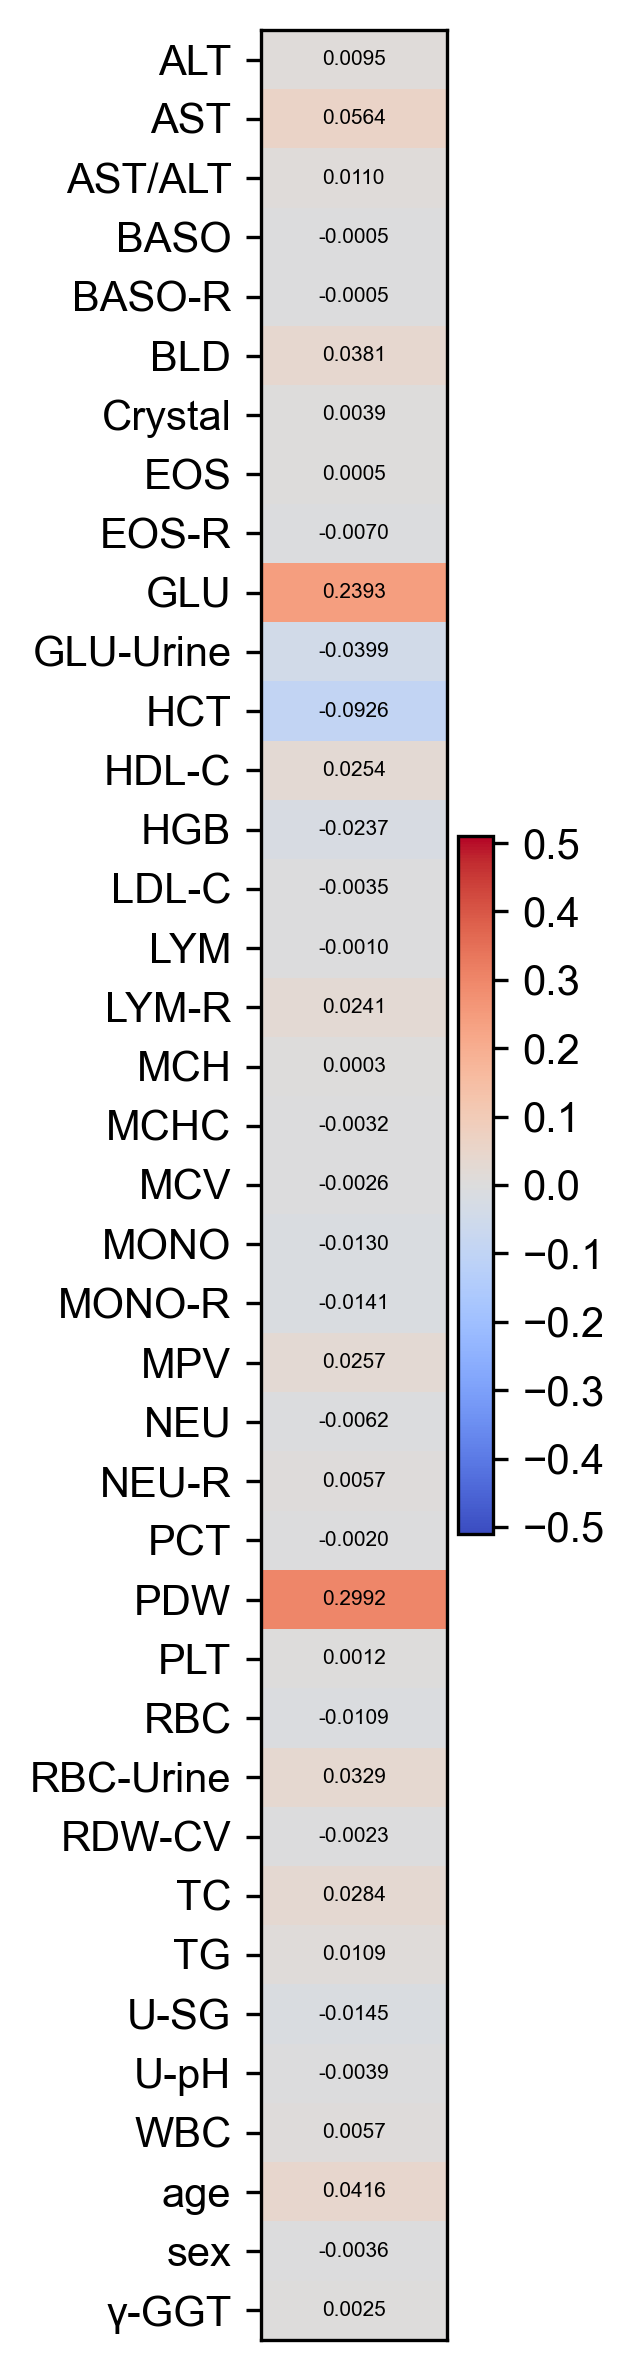

In [21]:
mean_path = 'mean_distF_tmp_test.pk'
ISA_main(datatmp,model_pre,2,mean_path=mean_path)